# Decision Trees as Surrogate Model for NNs

## Steps Taken

1. Train Neural Network using the data you have and make it generalize well
2. Generate a larger and evenly distributed set of training data by feeding a grid of data through the neural network
3. Use this new training data to train a decision tree
4. Decision tree will still overfit, but on data that is already very general (because of step 2)
5. Use typical regularization for decision tree not to make it generalize better, but to have a dial between explainability and accuracy
  1. depth
  2. number of leaf nodes
  3. etc.
6. Simple decision tree can be used to generated code
  1. multiple checks can be combined to one
  2. different style of code can be generated

## More on surrogate models
* https://en.wikipedia.org/wiki/Surrogate_model
* https://christophm.github.io/interpretable-ml-book/global.html

## And on model interpretation in general
* https://christophm.github.io/interpretable-ml-book/simple.html
* https://compstat-lmu.github.io/iml_methods_limitations/

## More detailed version with more experiments and different kinds of regularization: 

https://colab.research.google.com/github/DJCordhose/ml-workshop/blob/master/notebooks/tf2/tf-surrogate-model-details.ipynb


In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

dpi = 96
# dpi = 300

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (15, 8)
# mpl.rcParams["figure.dpi"] = dpi
mpl.rc('xtick', labelsize=15) 
mpl.rc('ytick', labelsize=15)

font_size=15
title_font_size=25

# https://matplotlib.org/users/colormaps.html
from matplotlib.colors import ListedColormap

colors = ['#FF0000', '#0000FF', '#FFFF00']

cmap = ListedColormap(colors) 

In [2]:
# Gives us a well defined version of tensorflow

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

# will also work, but nightly build might contain surprises

# !pip install -q tf-nightly-gpu-2.0-preview

TensorFlow 2.x selected.


In [3]:
import tensorflow as tf
print(tf.__version__)

2.1.0


In [0]:
random_seed = 42

In [0]:
tf.random.set_seed(random_seed)

In [0]:
import numpy as np

np.random.seed(random_seed)

In [0]:
# https://github.com/AndreasMadsen/python-lrcurve
!pip install -q lrcurve 

In [0]:
from lrcurve import KerasLearningCurve

In [0]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [0]:
# ignore this, it is just technical code to plot decision boundaries
# Adapted from:
# http://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html
# http://jponttuset.cat/xkcd-deep-learning/
# https://matplotlib.org/gallery/images_contours_and_fields/contourf_demo.html

from matplotlib.ticker import FuncFormatter

import numpy as np

def meshGrid(x_data=None, y_data=None):
    h = 1  # step size in the mesh
    x_min, x_max = 10, 110
    y_min, y_max = 80, 170
#     x_min, x_max = x_data.min() - 1, x_data.max() + 1
#     y_min, y_max = y_data.min() - 1, y_data.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return (xx,yy)

def plot_samples(samples, ax, legend):
    classes = samples[2]
    scatter = ax.scatter(samples[0], samples[1], c=classes, cmap=cmap, s=50, marker='o', edgecolors='k')

    # https://matplotlib.org/3.1.0/gallery/lines_bars_and_markers/scatter_with_legend.html
    formatter = FuncFormatter(lambda s,t: "Many Accidents" if s == 0 else "No Accidents" if s == 1 else "Few Accidents")
    class_legend = ax.legend(*scatter.legend_elements(alpha=0.6, prop='colors', fmt=formatter), title="Classes")
    ax.add_artist(class_legend)
    
    return ax, scatter

def plot_samples_markers(samples, ax, legend):
  y = samples[2]
  bad = samples[y == 0]
  good = samples[y == 1]
  fair = samples[y == 2]

  labels = ["High Risk", "Low Risk", "Medium Risk"]
  classes = [bad, good, fair]
  markers = ['v', 'd', '^']

  for label, clazz, color, marker in zip(labels, classes, colors, markers):
      ax.scatter(
          clazz[0], 
          clazz[1],
          label=label,
          color=color,
          marker=marker,
          s=100,
          edgecolors='k',
          alpha=0.8)
  if legend:
    ax.legend()
  return ax, None
      

def plotPrediction(clf, x_data, y_data, x_label, y_label, ground_truth, title="", 
                   n_samples=None, proba=True, prediction=True, legend=True, 
                   scatter=True,
                   ax=None
                  ):
    if x_data is not None:
      assert x_data.shape == y_data.shape, "x and y must have the same dimension"
    if x_data  is not None and ground_truth is not None:
      assert x_data.shape == ground_truth.shape, "input and ground truth need the same number of samples"
    xx,yy = meshGrid(x_data, y_data)
    if ax is None:
      fig, ax = plt.subplots()

    if clf:
        Z = clf.predict_proba(np.c_[yy.ravel(), xx.ravel()])

        if proba:
            probaZ = Z.max(axis=1)
            probaZ = probaZ.reshape(xx.shape)
            ax.contourf(xx, yy, probaZ, cmap=plt.cm.binary, alpha=.4)

        if prediction:
            Z = Z.argmax(axis=1)
            Z = Z.reshape(xx.shape)
            ax.contourf(xx, yy, Z, cmap=cmap, alpha=.3)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel(x_label, fontsize=font_size)
    ax.set_ylabel(y_label, fontsize=font_size)
    ax.set_title(title, fontsize=title_font_size)
    
    if scatter:
      samples = pd.DataFrame(np.array([x_data, y_data, ground_truth]).T)
      if n_samples:
        samples = samples.sample(n_samples, random_state=42)
      plot_samples_markers(samples, ax, legend)
    return ax 


In [0]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/DJCordhose/ml-workshop/master/data/insurance-customers-1500.csv', sep=';')

In [12]:
df.describe()

speed          age        miles        group
count  1500.000000  1500.000000  1500.000000  1500.000000
mean    122.492667    44.980667    30.434000     0.998667
std      17.604333    17.130400    15.250815     0.816768
min      68.000000    16.000000     1.000000     0.000000
25%     108.000000    32.000000    18.000000     0.000000
50%     120.000000    42.000000    29.000000     1.000000
75%     137.000000    55.000000    42.000000     2.000000
max     166.000000   100.000000    84.000000     2.000000

In [0]:
y = df['group'].values
X = df.drop('group', axis='columns').values

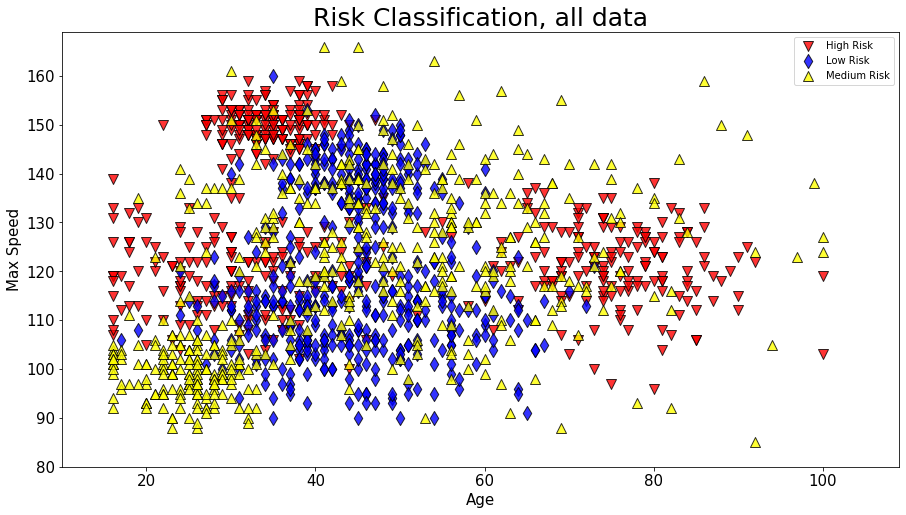

In [14]:
plotPrediction(clf=None, x_data=X[:, 1], y_data=X[:, 0], 
               x_label='Age', y_label='Max Speed', ground_truth=y,
                title="Risk Classification, all data");

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=random_seed, stratify=y)

## We just need the first two variables

In [0]:
# just the first two dimensions
X_train_2_dim = X_train[:, :2]
X_test_2_dim = X_test[:, :2]
X_2_dim = X[:, :2]

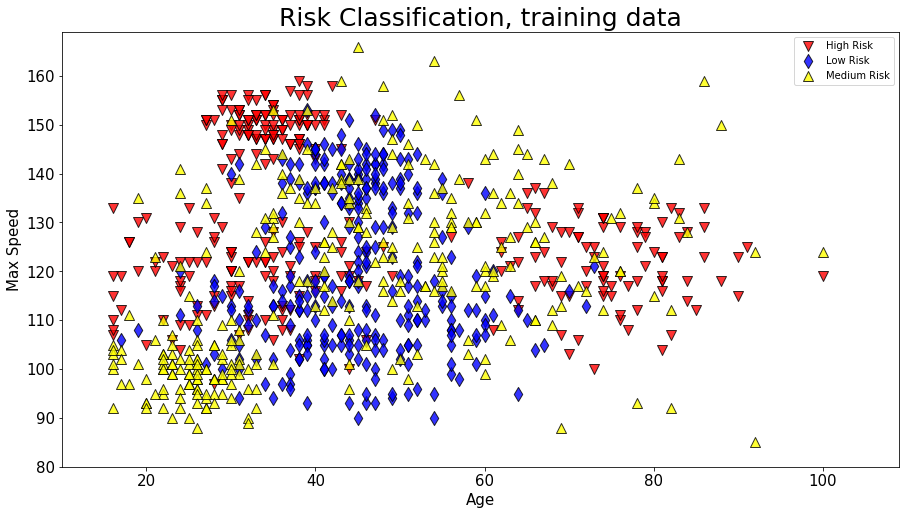

In [18]:
plotPrediction(clf=None, x_data=X_train[:, 1], y_data=X_train[:, 0], 
               x_label='Age', y_label='Max Speed', ground_truth=y_train,
                title="Risk Classification, training data");

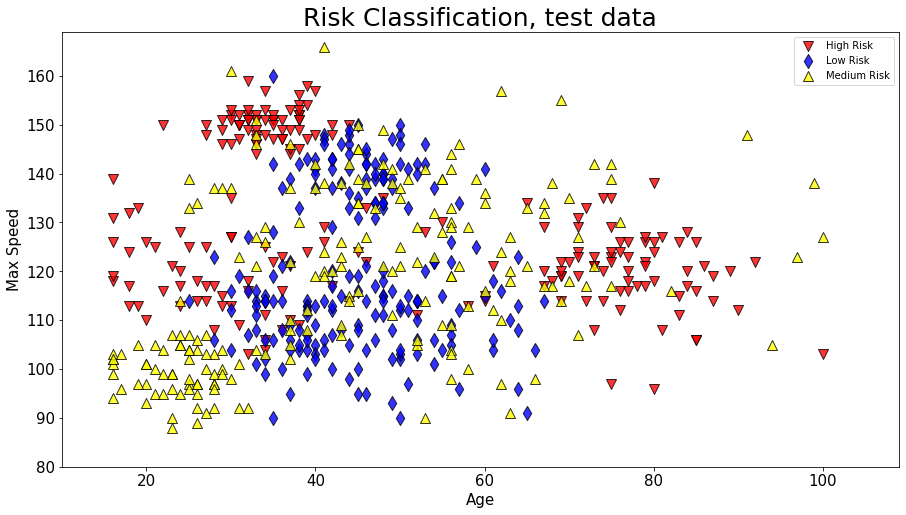

In [19]:
plotPrediction(clf=None, x_data=X_test[:, 1], y_data=X_test[:, 0], 
               x_label='Age', y_label='Max Speed', ground_truth=y_test,
               title="Risk Classification, test data");

# Step 1: Train Neural Network using the data you have and make it generalize well


There are many ways of regualizing, and all work reasonably well on a problem like this, more on regualirization: https://colab.research.google.com/github/DJCordhose/ml-workshop/blob/master/notebooks/tf-intro/2020-01-basics-regularization.ipynb

Self-Normalizing Neural Networks (https://arxiv.org/abs/1706.02515)
* https://www.tensorflow.org/api_docs/python/tf/keras/activations/selu
* https://www.tensorflow.org/api_docs/python/tf/keras/layers/AlphaDropout  

In [27]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, AlphaDropout

num_features = 2
num_categories = 3

dropout = 0.3
selu_dropout_model = tf.keras.Sequential()

selu_dropout_model.add(Input(name='input', shape=(num_features,)))

selu_dropout_model.add(Dense(name='hidden1', units=500, activation='selu', kernel_initializer=tf.initializers.lecun_normal(random_seed)))
selu_dropout_model.add(AlphaDropout(dropout))

selu_dropout_model.add(Dense(name='hidden2', units=250, activation='selu', kernel_initializer=tf.initializers.lecun_normal(random_seed)))
selu_dropout_model.add(AlphaDropout(dropout))

selu_dropout_model.add(Dense(name='output', units=num_categories, activation='softmax'))

selu_dropout_model.compile(loss='sparse_categorical_crossentropy',
             optimizer=tf.keras.optimizers.Adam(),
             metrics=['accuracy'])

model = selu_dropout_model
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 500)               1500      
_________________________________________________________________
alpha_dropout_4 (AlphaDropou (None, 500)               0         
_________________________________________________________________
hidden2 (Dense)              (None, 250)               125250    
_________________________________________________________________
alpha_dropout_5 (AlphaDropou (None, 250)               0         
_________________________________________________________________
output (Dense)               (None, 3)                 753       
Total params: 127,503
Trainable params: 127,503
Non-trainable params: 0
_________________________________________________________________


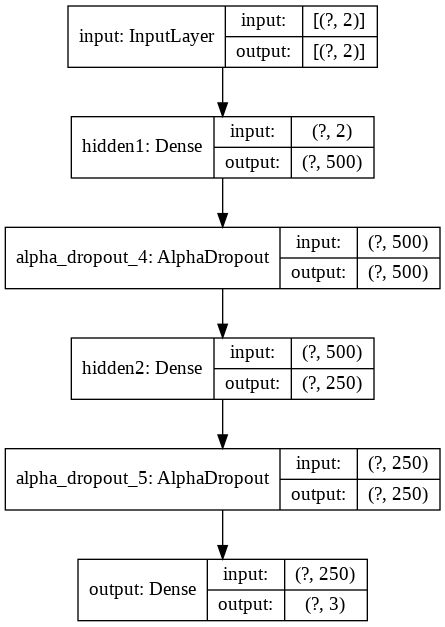

In [28]:
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True, dpi=dpi)

In [29]:
%%time 

# BATCH_SIZE = 10
BATCH_SIZE = 500
EPOCHS = 3000

PATIENCE = 500
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=PATIENCE)

history = model.fit(x = X_train_2_dim,
                    y = y_train,
                    validation_data=(X_test_2_dim, y_test),
                    epochs=EPOCHS, 
                    callbacks=[early_stopping_callback, KerasLearningCurve()],
                    # callbacks=[KerasLearningCurve()],
                    batch_size=BATCH_SIZE, 
                    verbose=0)

CPU times: user 33.5 s, sys: 2.9 s, total: 36.4 s
Wall time: 33.5 s


In [30]:
train_loss, train_accuracy = model.evaluate(X_train_2_dim, y_train, batch_size=BATCH_SIZE, verbose=0)
train_loss, train_accuracy

(0.883051766289605, 0.69777775)

In [31]:
test_loss, test_accuracy = model.evaluate(X_test_2_dim, y_test, batch_size=BATCH_SIZE, verbose=0)
test_loss, test_accuracy

(0.854252298672994, 0.69666666)

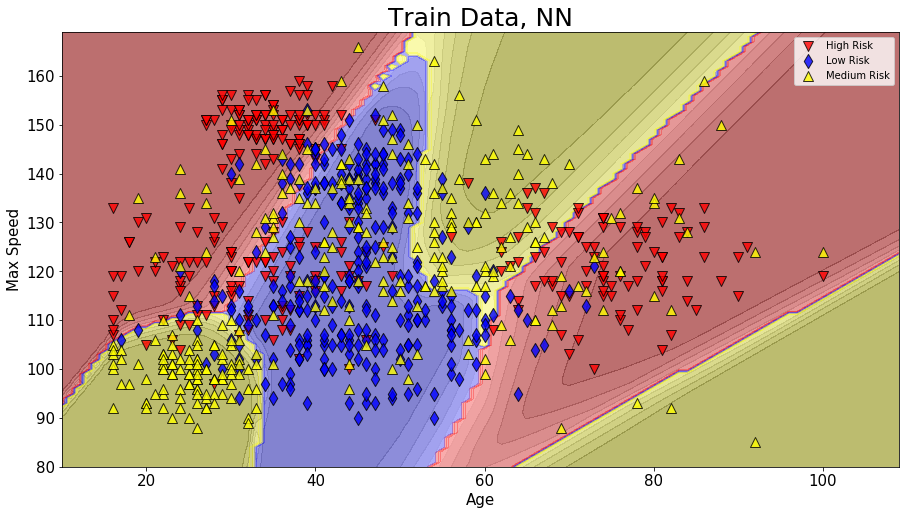

In [32]:
plotPrediction(model, X_train_2_dim[:, 1], X_train_2_dim[:, 0], 
               'Age', 'Max Speed', y_train,
                title="Train Data, NN");

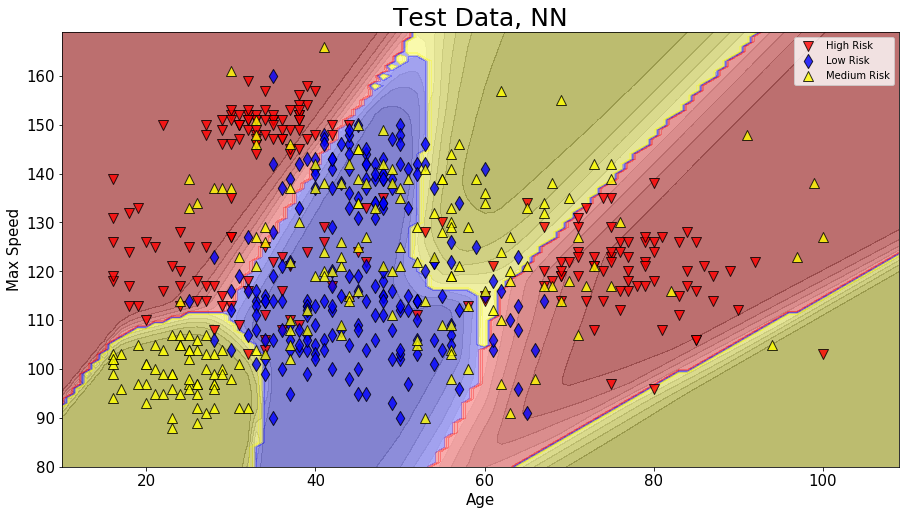

In [33]:
plotPrediction(model, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, NN");

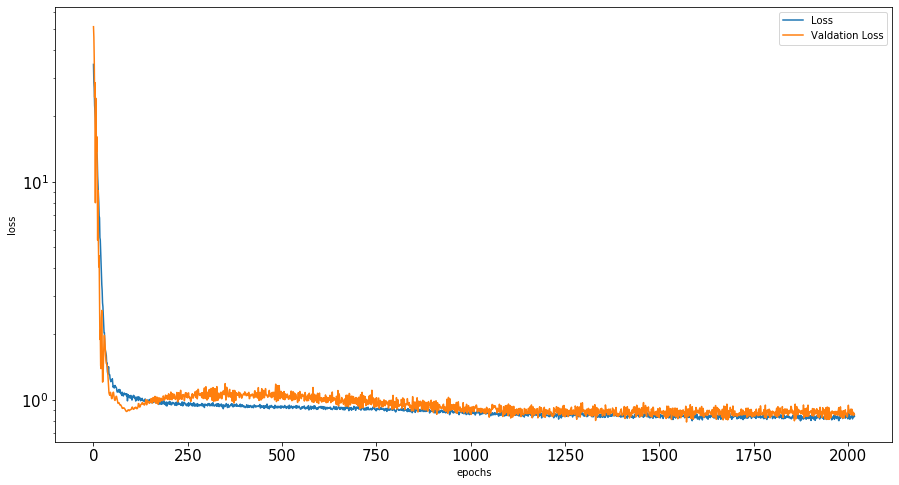

In [36]:
plt.yscale('log')

plt.ylabel("loss")
plt.xlabel("epochs")

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.legend(["Loss", "Valdation Loss"]);

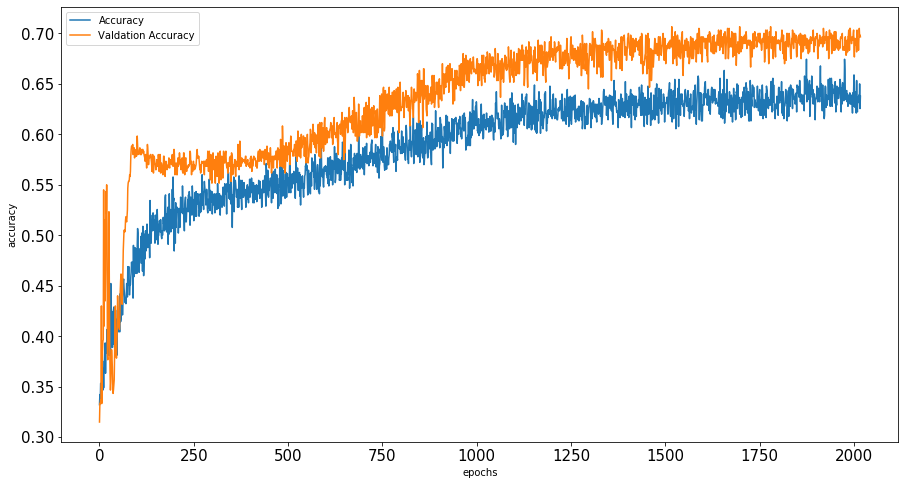

In [37]:
plt.ylabel("accuracy")
plt.xlabel("epochs")

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.legend(["Accuracy", "Valdation Accuracy"]);

# Step 2: Generate a larger and evenly distributed set of training data by feeding a grid of data through the neural network


In [45]:
xx,yy = meshGrid()
xx.shape, yy.shape

((90, 100), (90, 100))

In [46]:
mesh_data = np.c_[yy.ravel(), xx.ravel()]
mesh_data.shape

(9000, 2)

In [47]:
mesh_data[0]

array([80, 10])

In [48]:
pred = model.predict(mesh_data)
pred.shape

(9000, 3)

In [49]:
pred_sparse = pred.argmax(axis=1)
pred_sparse.shape

(9000,)

In [50]:
np.unique(pred_sparse, return_counts=True)

(array([0, 1, 2]), array([4425, 1565, 3010]))

In [0]:
from sklearn.tree import DecisionTreeClassifier

surrogate_model = DecisionTreeClassifier()
%time surrogate_model.fit(mesh_data, pred_sparse)

CPU times: user 10.4 ms, sys: 1.04 ms, total: 11.5 ms
Wall time: 12.8 ms


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

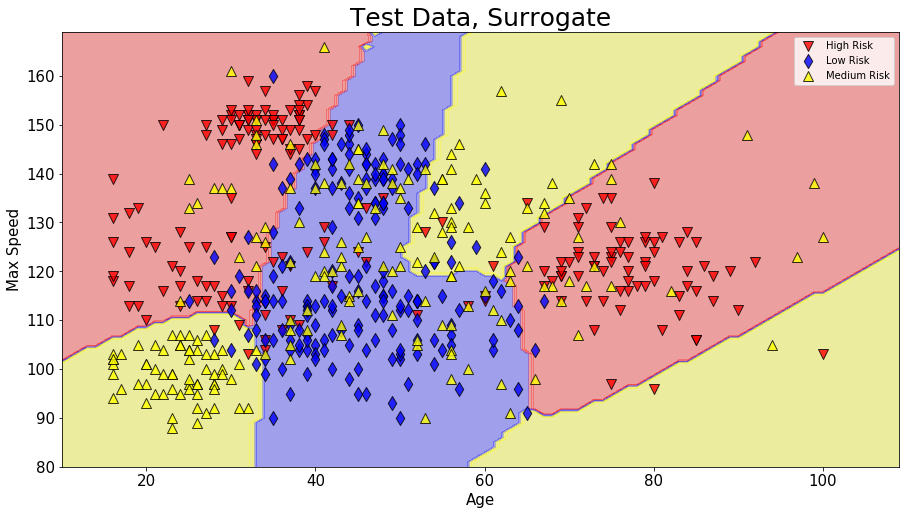

In [0]:
plotPrediction(surrogate_model, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, Surrogate");

In [0]:
surrogate_model.tree_.max_depth

13

In [0]:
surrogate_model.score(mesh_data, pred_sparse)

1.0

In [0]:
surrogate_model.score(X_train_2_dim, y_train)

0.7033333333333334

In [0]:
surrogate_model.score(X_test_2_dim, y_test)

0.7033333333333334

## Reduce Depth: 7

In [0]:
from sklearn.tree import DecisionTreeClassifier

surrogate_model = DecisionTreeClassifier(max_depth=7)
%time surrogate_model.fit(mesh_data, pred_sparse)

CPU times: user 9.43 ms, sys: 808 µs, total: 10.2 ms
Wall time: 11.7 ms


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=7, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [0]:
surrogate_model.tree_.max_depth

7

In [0]:
surrogate_model.score(mesh_data, pred_sparse)

0.9611111111111111

In [0]:
surrogate_model.score(X_train_2_dim, y_train)

0.6922222222222222

In [0]:
surrogate_model.score(X_test_2_dim, y_test)

0.695

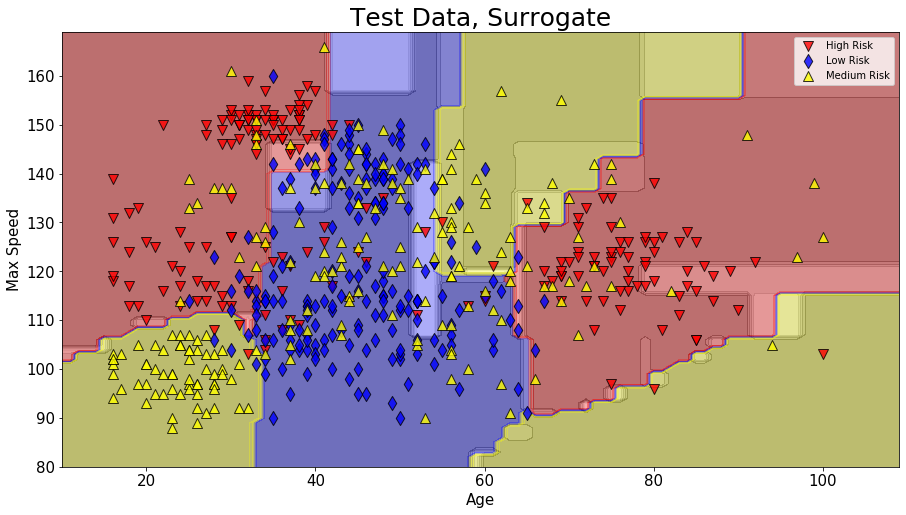

In [0]:
plotPrediction(surrogate_model, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, Surrogate");

In [0]:
# from sklearn.tree import plot_tree

# feature_names=['speed', 'age']
# class_names=['high', 'medium', 'low']

# plt.figure(figsize=(350, 50), dpi=96)
# plot_tree(surrogate_model, 
#           feature_names=feature_names,
#           class_names=class_names,
#           impurity=False,
#           label='none',
#           filled=True,
#           fontsize=25,
#           proportion=True);

## Reduce Depth: 5

In [0]:
from sklearn.tree import DecisionTreeClassifier

surrogate_model = DecisionTreeClassifier(max_depth=5)
%time surrogate_model.fit(mesh_data, pred_sparse)

CPU times: user 8.15 ms, sys: 901 µs, total: 9.05 ms
Wall time: 18.9 ms


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [0]:
surrogate_model.tree_.max_depth

5

In [0]:
surrogate_model.score(mesh_data, pred_sparse)

0.8978888888888888

In [0]:
surrogate_model.score(X_train_2_dim, y_train)

0.66

In [0]:
surrogate_model.score(X_test_2_dim, y_test)

0.6666666666666666

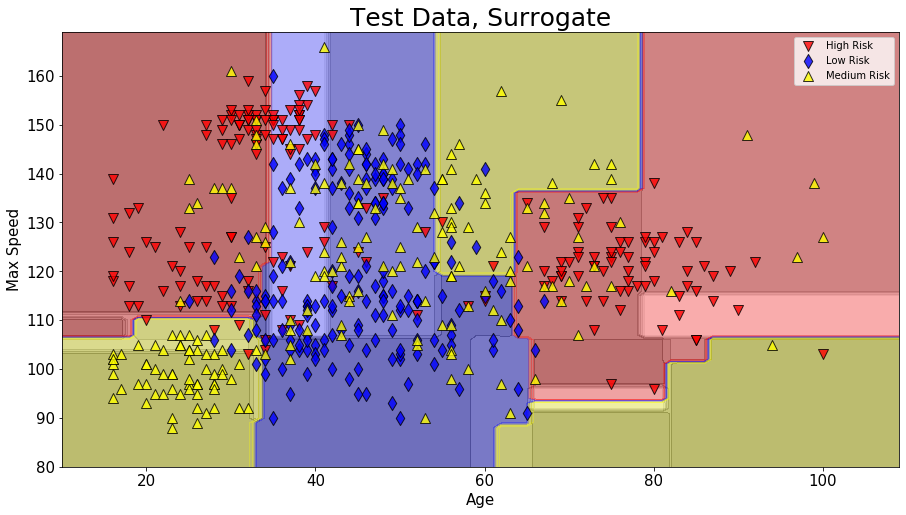

In [0]:
plotPrediction(surrogate_model, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, Surrogate");

## Reduce Depth: 4

In [0]:
from sklearn.tree import DecisionTreeClassifier

surrogate_model = DecisionTreeClassifier(max_depth=4)
%time surrogate_model.fit(mesh_data, pred_sparse)

CPU times: user 6.9 ms, sys: 995 µs, total: 7.89 ms
Wall time: 20.8 ms


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [0]:
surrogate_model.tree_.max_depth

4

In [0]:
surrogate_model.score(mesh_data, pred_sparse)

0.8362222222222222

In [0]:
surrogate_model.score(X_train_2_dim, y_train)

0.6088888888888889

In [0]:
surrogate_model.score(X_test_2_dim, y_test)

0.6183333333333333

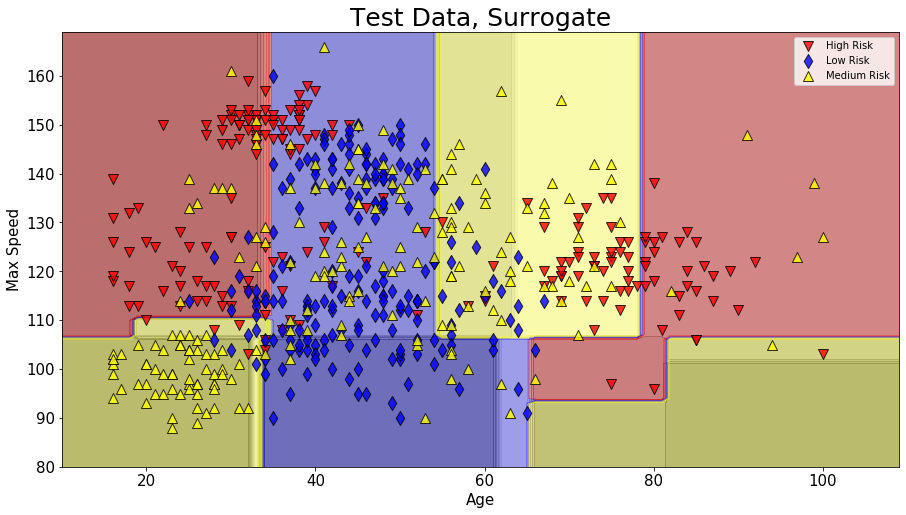

In [0]:
plotPrediction(surrogate_model, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, Surrogate");

## Reduce Depth: 3

In [0]:
from sklearn.tree import DecisionTreeClassifier

# surrogate_model = DecisionTreeClassifier(max_depth=3, min_samples_leaf=250)
surrogate_model = DecisionTreeClassifier(max_depth=3)

%time surrogate_model.fit(mesh_data, pred_sparse)

CPU times: user 6.37 ms, sys: 0 ns, total: 6.37 ms
Wall time: 7.7 ms


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [0]:
surrogate_model.tree_.max_depth

3

In [0]:
surrogate_model.score(mesh_data, pred_sparse)

0.7831111111111111

In [0]:
surrogate_model.score(X_train_2_dim, y_train)

0.6211111111111111

In [0]:
surrogate_model.score(X_test_2_dim, y_test)

0.6266666666666667

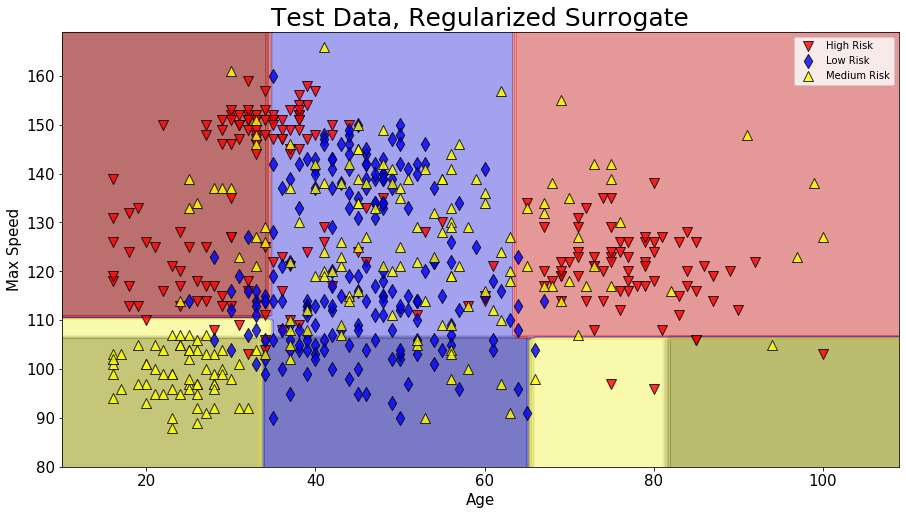

In [0]:
plotPrediction(surrogate_model, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, Regularized Surrogate");

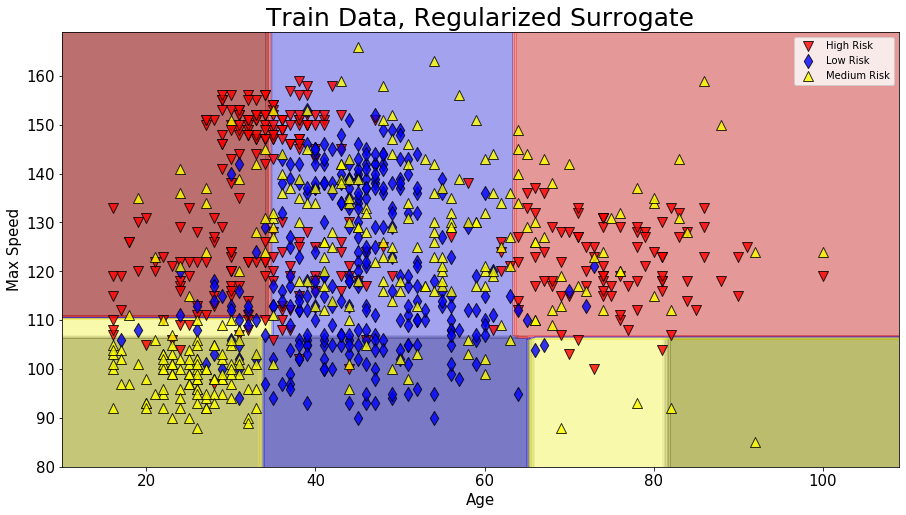

In [0]:
plotPrediction(surrogate_model, X_train_2_dim[:, 1], X_train_2_dim[:, 0], 
               'Age', 'Max Speed', y_train,
                title="Train Data, Regularized Surrogate");

## Reduce Depth: 2

In [0]:
from sklearn.tree import DecisionTreeClassifier

surrogate_model = DecisionTreeClassifier(max_depth=2)

%time surrogate_model.fit(mesh_data, pred_sparse)

CPU times: user 4.8 ms, sys: 991 µs, total: 5.79 ms
Wall time: 6.79 ms


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [0]:
surrogate_model.tree_.max_depth

2

In [0]:
surrogate_model.score(mesh_data, pred_sparse)

0.621

In [0]:
surrogate_model.score(X_train_2_dim, y_train)

0.40555555555555556

In [0]:
surrogate_model.score(X_test_2_dim, y_test)

0.405

In [0]:
surrogate_model.score(X_2_dim, y)

0.4053333333333333

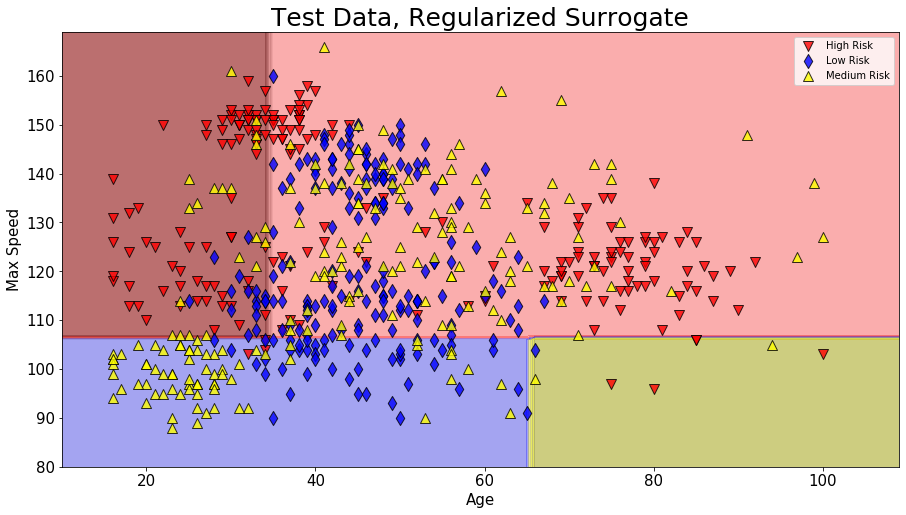

In [0]:
plotPrediction(surrogate_model, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, Regularized Surrogate");

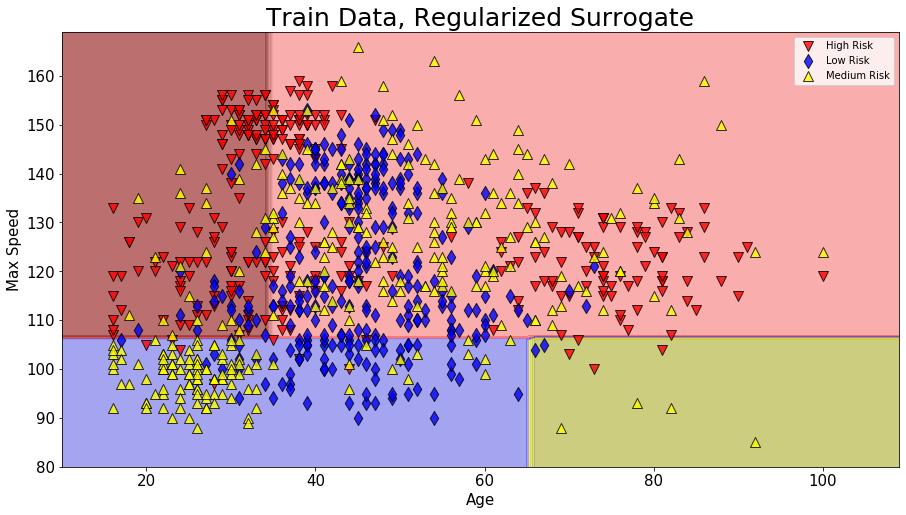

In [0]:
plotPrediction(surrogate_model, X_train_2_dim[:, 1], X_train_2_dim[:, 0], 
               'Age', 'Max Speed', y_train,
                title="Train Data, Regularized Surrogate");

## Reduce Depth: 1

In [0]:
from sklearn.tree import DecisionTreeClassifier

surrogate_model = DecisionTreeClassifier(max_depth=1)

%time surrogate_model.fit(mesh_data, pred_sparse)

CPU times: user 2.45 ms, sys: 1.87 ms, total: 4.33 ms
Wall time: 5.82 ms


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=1, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [0]:
surrogate_model.tree_.max_depth

1

In [0]:
surrogate_model.score(mesh_data, pred_sparse)

0.6023333333333334

In [0]:
surrogate_model.score(X_train_2_dim, y_train)

0.45

In [0]:
surrogate_model.score(X_test_2_dim, y_test)

0.44166666666666665

In [0]:
surrogate_model.score(X_2_dim, y)

0.44666666666666666

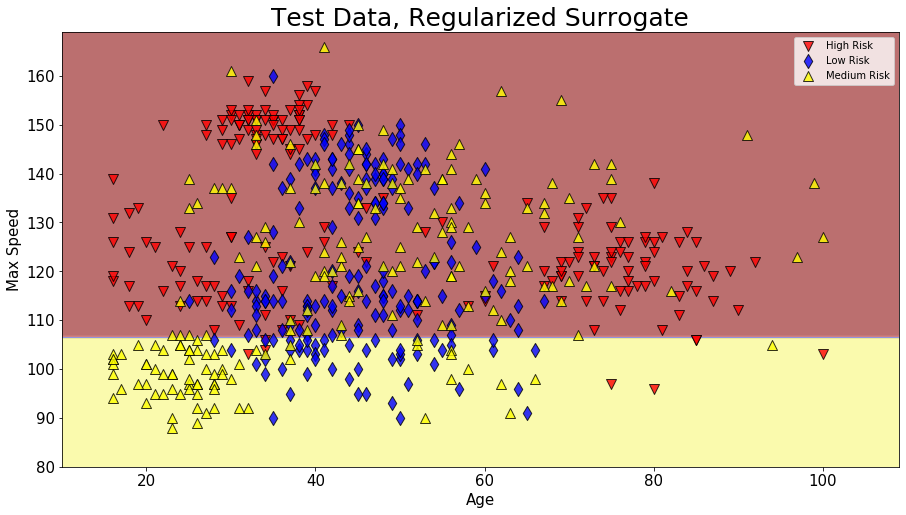

In [0]:
plotPrediction(surrogate_model, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, Regularized Surrogate");

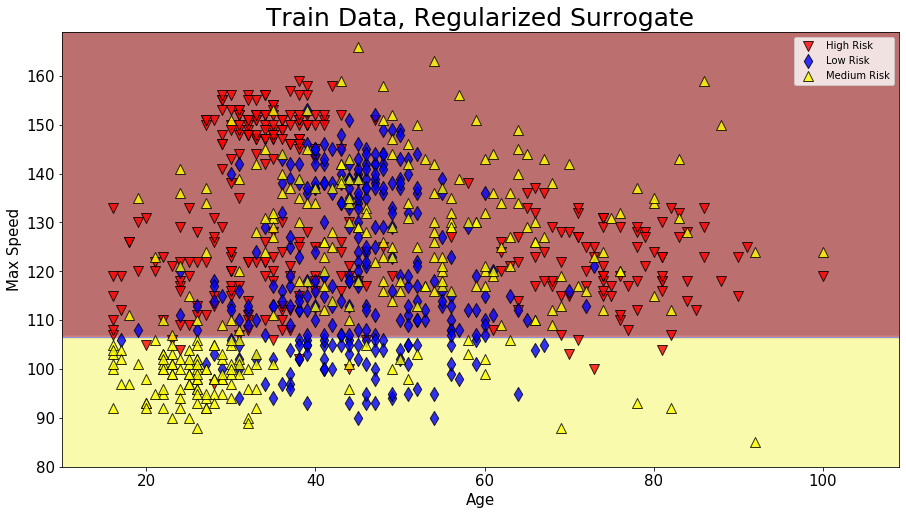

In [0]:
plotPrediction(surrogate_model, X_train_2_dim[:, 1], X_train_2_dim[:, 0], 
               'Age', 'Max Speed', y_train,
                title="Train Data, Regularized Surrogate");

## Analyze for simple, but reasonable tree

In [0]:
from sklearn.tree import DecisionTreeClassifier

surrogate_model = DecisionTreeClassifier(
    max_depth=4,
    # max_leaf_nodes = 4
    max_leaf_nodes = 6
                                         )
%time surrogate_model.fit(mesh_data, pred_sparse)

CPU times: user 7.61 ms, sys: 0 ns, total: 7.61 ms
Wall time: 7.46 ms


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=6,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [0]:
surrogate_model.tree_.max_depth

3

In [0]:
surrogate_model.score(mesh_data, pred_sparse)

0.7824444444444445

In [0]:
surrogate_model.score(X_train_2_dim, y_train)

0.6255555555555555

In [0]:
surrogate_model.score(X_test_2_dim, y_test)

0.625

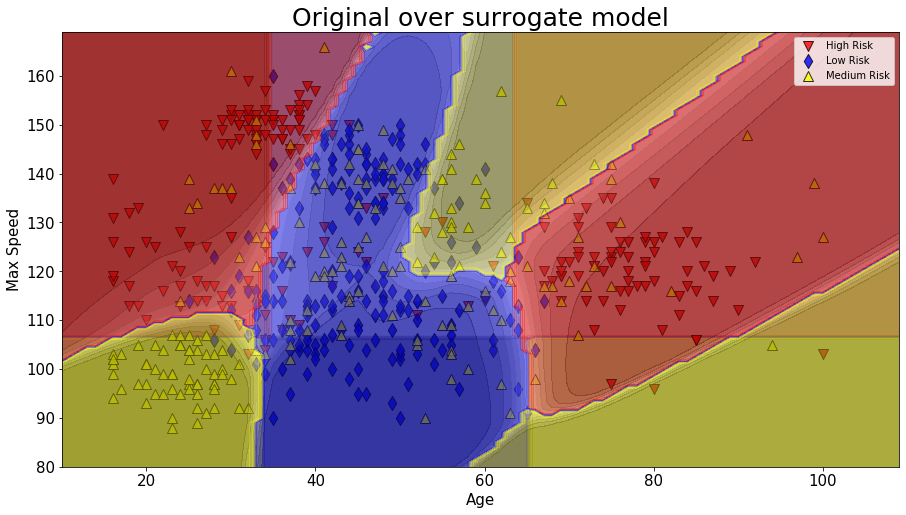

In [0]:
ax = plotPrediction(surrogate_model, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test)
plotPrediction(model, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test, ax=ax, scatter=False,
                title="Original over surrogate model");

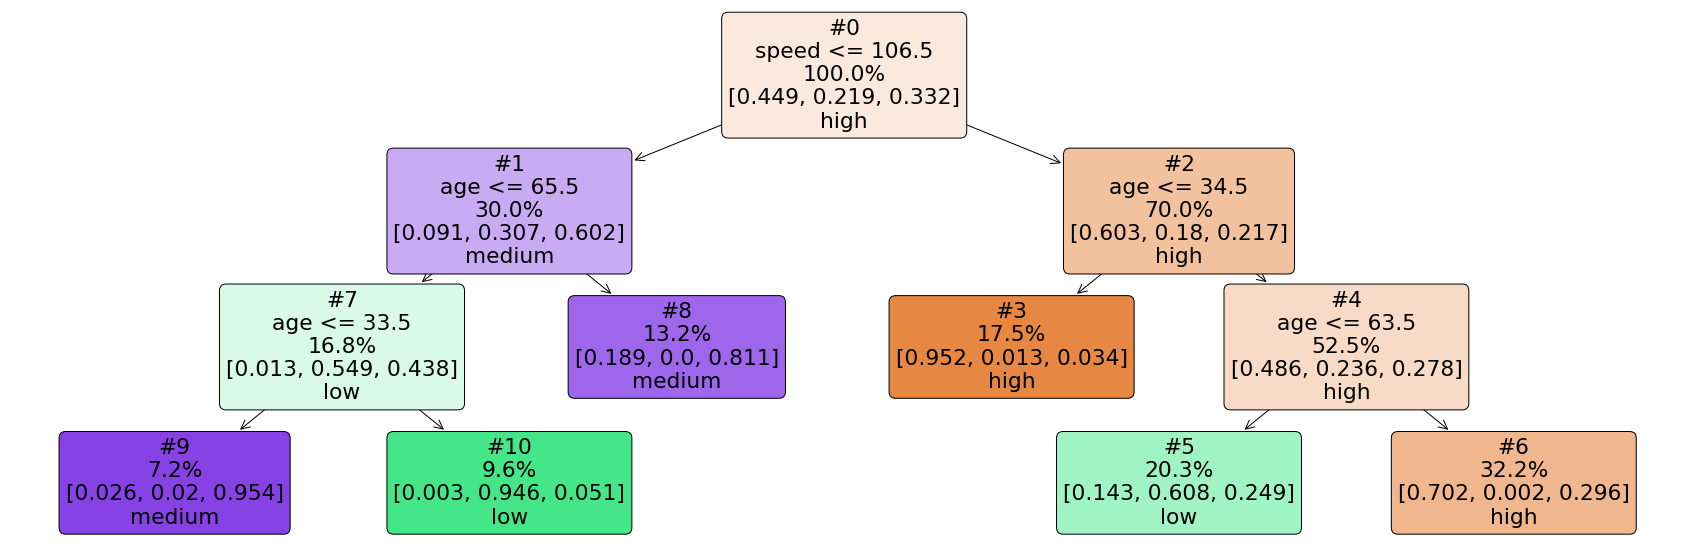

In [0]:
# https://scikit-learn.org/stable/modules/tree.html
# https://scikit-learn.org/stable/auto_examples/tree/plot_iris_dtc.html
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html
# https://stackoverflow.com/questions/42891148/changing-colors-for-decision-tree-plot-created-using-export-graphviz
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

feature_names=['speed', 'age']
class_names=['high', 'low', 'medium']

plt.figure(figsize=(30, 10))
plot_tree(surrogate_model, 
          feature_names=feature_names,
          class_names=class_names,
          impurity=False,
          label='none',
          rounded=True,
          node_ids=True,
          proportion=True,
          filled=True);

In [0]:
sample = [100, 35]
# sample = [100, 60]
# sample = [120, 17]

In [0]:
surrogate_model.predict([sample])

array([1])

In [0]:
leaf_id = surrogate_model.apply([sample])
leaf_id

array([10])

In [0]:
node_indicator = surrogate_model.decision_path([sample])
node_index = node_indicator.indices[node_indicator.indptr[0]:
                                    node_indicator.indptr[1]]
node_index

array([ 0,  1,  7, 10], dtype=int32)

## Analyzing tree structure

In [0]:
# https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html

from sklearn.tree import _tree

def explain_decision(model, sample, feature_names, class_names):

  feature = model.tree_.feature
  threshold = model.tree_.threshold
  value = model.tree_.value

  node_indicator = model.decision_path([sample])
  node_index = node_indicator.indices[node_indicator.indptr[0]:
                                      node_indicator.indptr[1]]

  for node_id in node_index:
      if feature[node_id] == _tree.TREE_UNDEFINED:
          print(class_names[value[node_id].argmax(axis=1)[0]])
          continue

      if (sample[feature[node_id]] <= threshold[node_id]):
          threshold_sign = "<="
      else:
          threshold_sign = ">"

      print("%s(= %s) %s %s"
            % (feature_names[feature[node_id]],
              sample[feature[node_id]],
              threshold_sign,
              threshold[node_id]))
      
explain_decision(surrogate_model, sample, feature_names, class_names)      

speed(= 100) <= 106.5
age(= 35) <= 65.5
age(= 35) > 33.5
low


In [0]:
# derived from https://stackoverflow.com/questions/20224526/how-to-extract-the-decision-rules-from-scikit-learn-decision-tree

# derived from https://stackoverflow.com/questions/20224526/how-to-extract-the-decision-rules-from-scikit-learn-decision-tree

def generate_code(model, feature_names, class_names, flat=False, batch=True):
    tree_ = model.tree_
    feature = model.tree_.feature
    threshold = model.tree_.threshold
    value = model.tree_.value

    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    print ("def tree({}):".format(", ".join(feature_names)))

    def recurse(node, depth, conditions, outputs):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            condition = "{} <= {}".format(name, threshold)
            if not flat:
              print ("{}if {}:".format(indent, condition))
            recurse(tree_.children_left[node], depth + 1, conditions + [condition], outputs)
            condition = "{} > {}".format(name, threshold)
            if not flat:
              print ("{}else:  # if {}".format(indent, condition))
            recurse(tree_.children_right[node], depth + 1, conditions + [condition], outputs)
        else:
            prediction = class_names[value[node].argmax(axis=1)[0]]
            conjunction = ' and '.join(conditions)
            if flat and not batch:
              print ("  if {}:".format(conjunction))
            if not flat or not batch:
              print ("{}return '{}'".format(indent, prediction))
            else:
                if prediction in outputs: 
                  outputs[prediction] += [conjunction] 
                else:
                  outputs[prediction] = [conjunction]
        return outputs
              

    outputs = recurse(0, 1, [], {})
    if flat and batch:
      for prediction in outputs.keys():
          conjunctions = outputs[prediction]
          disjunction = ' or\n     '.join(conjunctions)
          print ("  if {}:".format(disjunction))
          print ("    return '{}':".format(prediction))
    
generate_code(surrogate_model, feature_names, class_names)    

def tree(speed, age):
  if speed <= 106.5:
    if age <= 65.5:
      if age <= 33.5:
        return 'medium'
      else:  # if age > 33.5
        return 'low'
    else:  # if age > 65.5
      return 'medium'
  else:  # if speed > 106.5
    if age <= 34.5:
      return 'high'
    else:  # if age > 34.5
      if age <= 63.5:
        return 'low'
      else:  # if age > 63.5
        return 'high'


### Visualizing Prediction Path using dtreeviz

https://github.com/parrt/dtreeviz

In [0]:
import sys

if 'google.colab' in sys.modules:
  !pip install -q dtreeviz

In [0]:
from sklearn.tree import DecisionTreeClassifier

surrogate_model = DecisionTreeClassifier(
    max_depth=3,
    criterion='entropy',
    random_state=random_seed,
    max_leaf_nodes = 5)
%time surrogate_model.fit(mesh_data, pred_sparse)

CPU times: user 7.89 ms, sys: 0 ns, total: 7.89 ms
Wall time: 9.36 ms


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=3, max_features=None, max_leaf_nodes=5,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [0]:
surrogate_model.feature_importances_

array([0.23873685, 0.76126315])

In [0]:
surrogate_model.score(mesh_data, pred_sparse)

0.6942222222222222

In [0]:
surrogate_model.score(X_train_2_dim, y_train)

0.6033333333333334

In [0]:
surrogate_model.score(X_test_2_dim, y_test)

0.6283333333333333

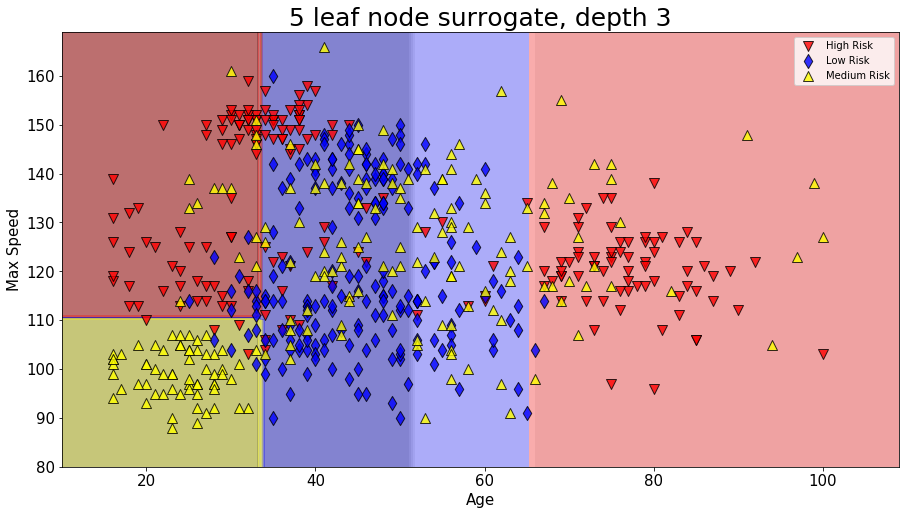

In [0]:
plotPrediction(surrogate_model, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="5 leaf node surrogate, depth 3");

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


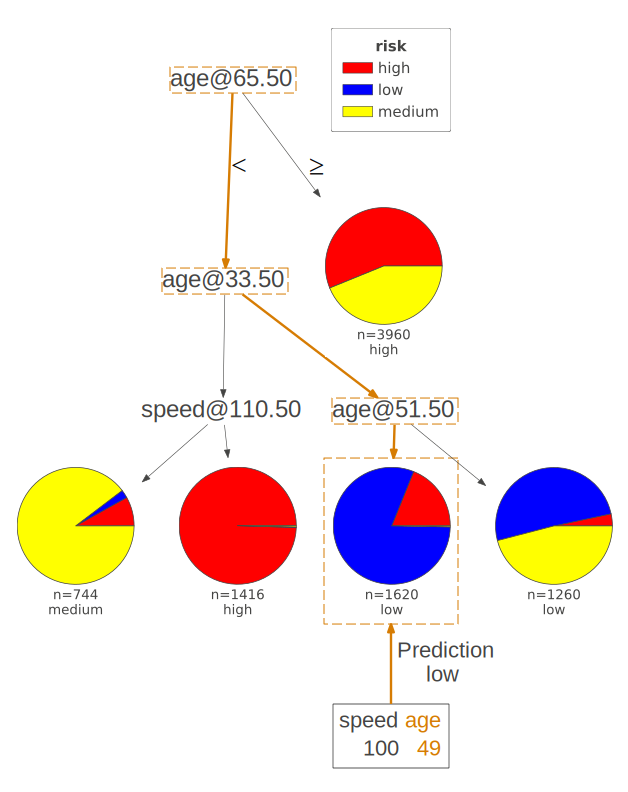

In [0]:
from dtreeviz.trees import dtreeviz

# sample = [100, 35]
# sample = [150, 30]
sample = [100, 49]
# sample = [100, 60]
# sample = [120, 17]

dtreeviz_colors = {'classes': [
                   None,  # 0 classes
                   None,  # 1 classes
                   None,  # 2 classes
                   colors
                   ]}

viz = dtreeviz(surrogate_model,
               mesh_data, pred_sparse,
               target_name='risk',
               feature_names=feature_names,
               class_names=class_names,
               X=sample,
               colors=dtreeviz_colors,
               fancy=False,
               scale=2,
#                scale=3
)
viz

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


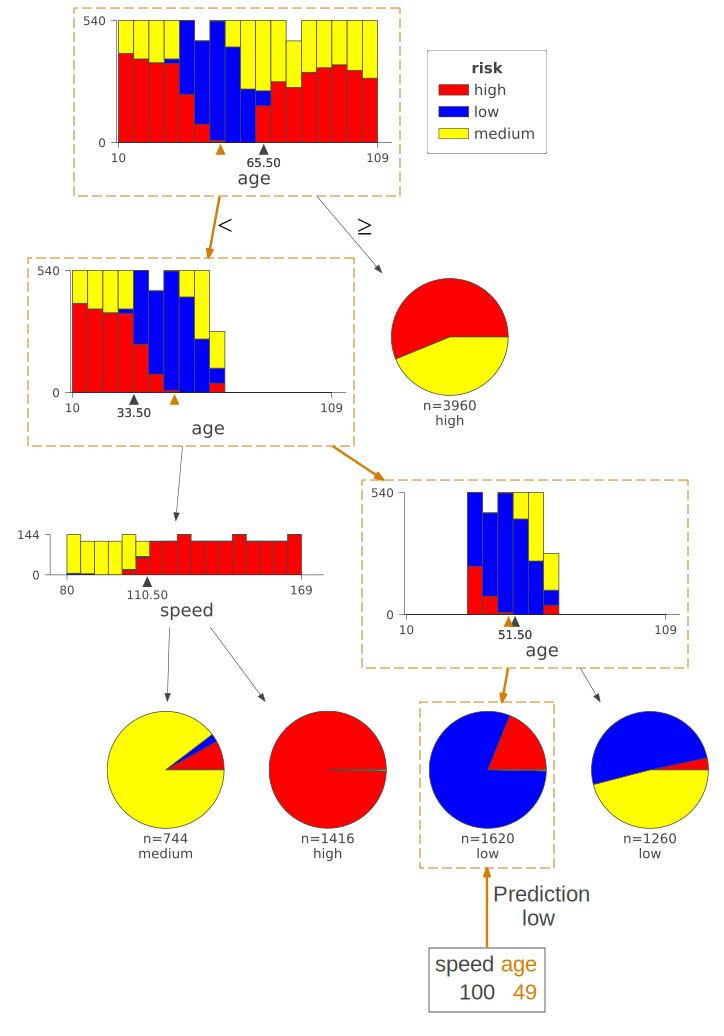

In [0]:
dtreeviz(surrogate_model,
         mesh_data, pred_sparse,
         target_name='risk',
         feature_names=feature_names,
         class_names=class_names,
         X=sample,
         colors=dtreeviz_colors,
         scale=2)

## Even KNN is an option now, since we are no longer working on real data

In [0]:
from sklearn.neighbors import KNeighborsClassifier
surrogate_model = KNeighborsClassifier(n_neighbors=5)
%time surrogate_model.fit(mesh_data, pred_sparse)

CPU times: user 9.01 ms, sys: 1.12 ms, total: 10.1 ms
Wall time: 11 ms


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [0]:
surrogate_model.score(mesh_data, pred_sparse)

0.9993333333333333

In [0]:
surrogate_model.score(X_train_2_dim, y_train)

0.7033333333333334

In [0]:
surrogate_model.score(X_test_2_dim, y_test)

0.7033333333333334

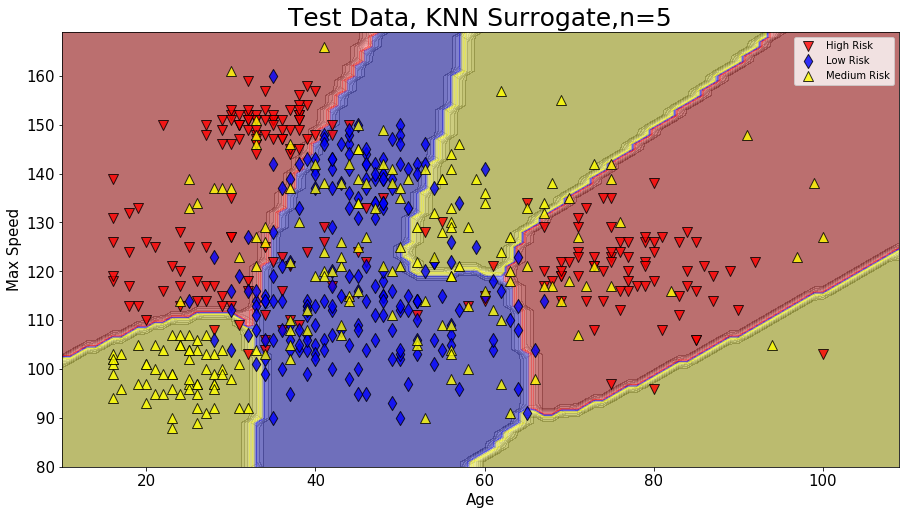

In [0]:
plotPrediction(surrogate_model, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, KNN Surrogate,n=5");

In [0]:
from sklearn.neighbors import KNeighborsClassifier
surrogate_model = KNeighborsClassifier(n_neighbors=1)
%time surrogate_model.fit(mesh_data, pred_sparse)

CPU times: user 8.29 ms, sys: 1.04 ms, total: 9.32 ms
Wall time: 24.6 ms


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [0]:
surrogate_model.score(mesh_data, pred_sparse)

1.0

In [0]:
surrogate_model.score(X_train_2_dim, y_train)

0.7033333333333334

In [0]:
surrogate_model.score(X_test_2_dim, y_test)

0.7033333333333334

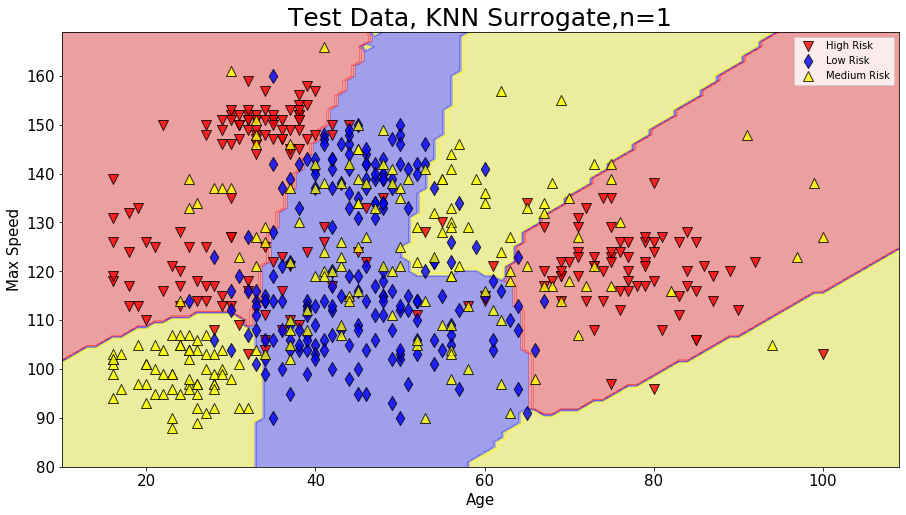

In [0]:
plotPrediction(surrogate_model, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, KNN Surrogate,n=1");

## Experimentes to stabilize the Decision Tree

In [0]:
from sklearn.tree import DecisionTreeClassifier

surrogate_model = DecisionTreeClassifier(
    max_depth=3,
    max_leaf_nodes = 6,
    min_samples_leaf = 500,
    random_state=random_seed)
%time surrogate_model.fit(mesh_data, pred_sparse)

CPU times: user 5.29 ms, sys: 929 µs, total: 6.22 ms
Wall time: 5.93 ms


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=6,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=500, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [0]:
surrogate_model.tree_.max_depth

3

In [0]:
surrogate_model.score(mesh_data, pred_sparse)

0.7824444444444445

In [0]:
surrogate_model.score(X_train_2_dim, y_train)

0.6255555555555555

In [0]:
surrogate_model.score(X_test_2_dim, y_test)

0.625

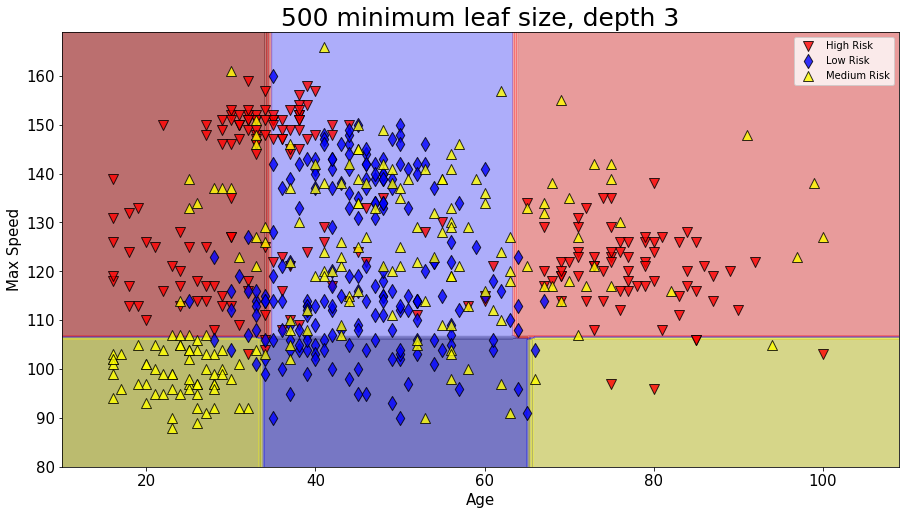

In [0]:
plotPrediction(surrogate_model, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="500 minimum leaf size, depth 3");

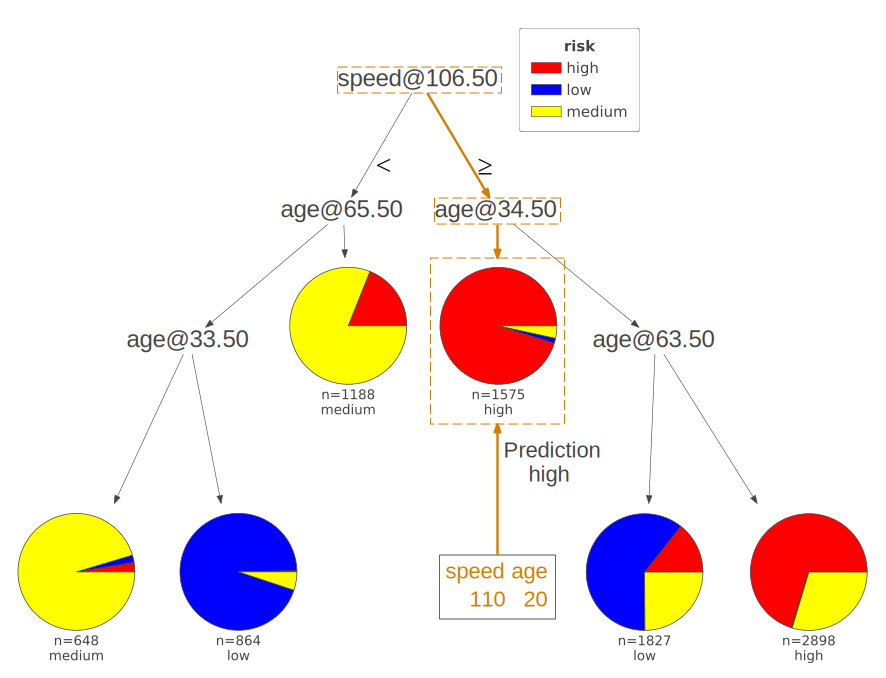

In [0]:
sample = [110, 20]

viz = dtreeviz(surrogate_model,
               mesh_data, pred_sparse,
               target_name='risk',
               feature_names=feature_names,
               class_names=class_names,
               X=sample,
               colors=dtreeviz_colors,
               fancy=False,
               scale=2,
)
viz

In [0]:
generate_code(surrogate_model, feature_names, class_names, flat=False)

def tree(speed, age):
  if speed <= 106.5:
    if age <= 65.5:
      if age <= 33.5:
        return 'medium'
      else:  # if age > 33.5
        return 'low'
    else:  # if age > 65.5
      return 'medium'
  else:  # if speed > 106.5
    if age <= 34.5:
      return 'high'
    else:  # if age > 34.5
      if age <= 63.5:
        return 'low'
      else:  # if age > 63.5
        return 'high'


In [0]:
generate_code(surrogate_model, feature_names, class_names, flat=True, batch=False)

def tree(speed, age):
  if speed <= 106.5 and age <= 65.5 and age <= 33.5:
        return 'medium'
  if speed <= 106.5 and age <= 65.5 and age > 33.5:
        return 'low'
  if speed <= 106.5 and age > 65.5:
      return 'medium'
  if speed > 106.5 and age <= 34.5:
      return 'high'
  if speed > 106.5 and age > 34.5 and age <= 63.5:
        return 'low'
  if speed > 106.5 and age > 34.5 and age > 63.5:
        return 'high'


In [0]:
generate_code(surrogate_model, feature_names, class_names, flat=True)

def tree(speed, age):
  if speed <= 106.5 and age <= 65.5 and age <= 33.5 or
     speed <= 106.5 and age > 65.5:
    return 'medium':
  if speed <= 106.5 and age <= 65.5 and age > 33.5 or
     speed > 106.5 and age > 34.5 and age <= 63.5:
    return 'low':
  if speed > 106.5 and age <= 34.5 or
     speed > 106.5 and age > 34.5 and age > 63.5:
    return 'high':


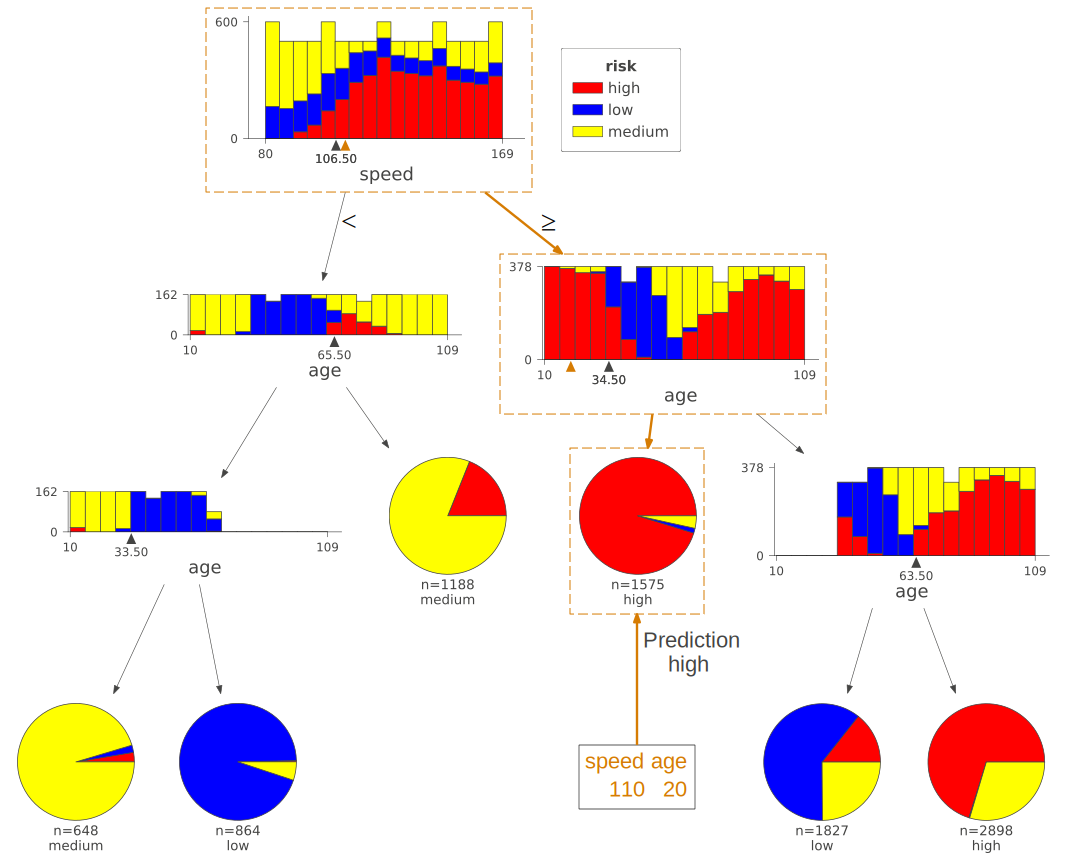

In [0]:
dtreeviz(surrogate_model,
         mesh_data, pred_sparse,
         target_name='risk',
         feature_names=feature_names,
         class_names=class_names,
         X=sample,
         colors=dtreeviz_colors,
         scale=2)

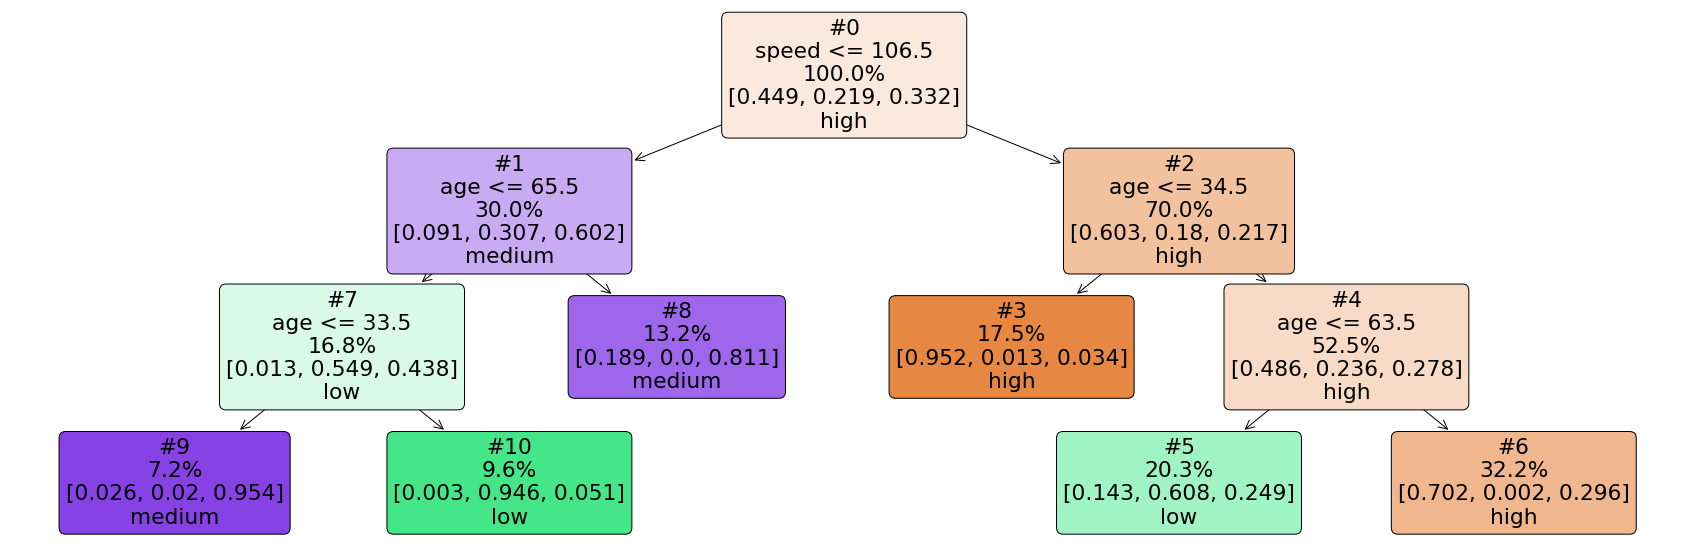

In [0]:
from sklearn.tree import plot_tree

plt.figure(figsize=(30, 10))
plot_tree(surrogate_model, 
          feature_names=feature_names,
          class_names=class_names,
          impurity=False,
          label='none',
          rounded=True,
          node_ids=True,
          proportion=True,
          filled=True);